# Overview

In this series of labs, we will tackle the challenges of Facial Landmark Recognition and Facial Expression Recognition. Our goal is to add special effects to specific key points based on the detected emotions. Through this lab, we will explore how AI can enhance user interaction and experience with dynamic and responsive visual effects.

It covers facial landmarks detection and expression recognition using advanced AI techniques. The goal is to detect facial landmarks accurately and recognize facial expressions to trigger specific special effects that enhance the interaction. In this lab, we continue to work on facial landmarks detection with pre-trained models. It is a continuation of the previous lab, where we have learned how to train a facial expression recognition model with a simple CNN architecture and doing data augmentation in PyTorch `Dataset`.

In this lab, we will try to do data augmentation using the `transforms` pipeline and fine-tune a pre-trained model to detect facial landmarks. Additionally, we will build on our previous class on Facial Expression Recognition to implement special effects based on detected emotions. This will involve integrating emotion detection algorithms and custom effects to create a seamless and engaging user experience.

# Background

Automatic effects use facial recognition and expression detection to apply real-time visual or audio effects based on a user's facial features and emotions. This technology enhances user engagement in applications like social media filters, live streaming, video chat, virtual try-ons, gaming, and therapeutic tools. By detecting facial landmarks and recognizing expressions, systems can dynamically respond with effects, creating interactive and immersive experiences.

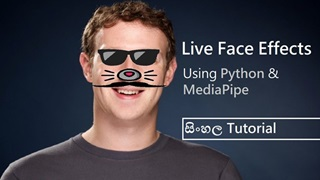

# Facial Landmarks Detection

Facial landmarks detection is a computer vision task that involves detecting key points on a person’s face, such as the eyes, nose, and mouth. It is a crucial task in many applications, such as face recognition, facial expression analysis, and driver status monitoring system in the Full Self-Driving (FSD) system. There are numerous methods to detect facial landmarks, such as regression-based methods, heatmap-based methods, and deep learning-based methods.

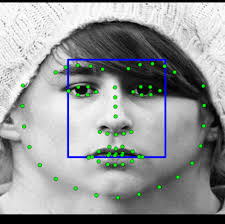

# Objectives

In this lab, we will try to do data augmentation using transforms pipeline and fine-tune a pre-trained model to detect facial landmarks. The lab will cover the following topics:

* Data Augmentation using transforms pipeline
* Fine-tuning a pre-trained model
* Evaluating the model

# Requirements

Requirements
Before starting this lab, you should have the following:

* Basic knowledge of Python
* Basic knowledge of PyTorch
* Basic knowledge of Convolutional Neural Networks (CNNs)
* Basic knowledge of Facial Landmarks Detection

#**Case Study**

First, we need to download the dataset and extract it to the current directory.
The dataset contains images of faces with facial landmarks annotations. The dataset is divided into two parts: a training set and a validation set. Both set contains 2,500 images with a face bounding box and 5 facial landmarks annotations. The dataset is available in this link. You can download the dataset and extract it to the data directory in the same directory as this notebook. The dataset directory should have the following structure:


```
lfw_5590/
    Aaron_Eckhart_0001.jpg
    ...
net_7876/
    Aaron_Eckhart_0001.jpg
    ...
testImageList.txt
trainImageList.txt
```

In `trainImageList.txt` and `testImageList.txt`, each line contains the path to an image, face bounding box and the corresponding facial landmarks annotations. The annotations are in the format of `image_path, bbox_x1, bbox_x2, bbox_y1, bbox_y2, x1, y1, x2, y2, x3, y3, x4, y4, x5, y5`, where `(x1, y1)` to `(x5, y5)` are the coordinates of the 5 facial landmarks.

In [1]:
import urllib.request
import zipfile
import os

def download_and_extract_zip(url):
    # Extract the filename from the URL
    filename = url.split('/')[-1]

    # Download the zip file
    urllib.request.urlretrieve(url, filename)

    # Extract the contents of the zip file
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()

    # Remove the downloaded zip file
    os.remove(filename)

download_and_extract_zip("http://mmlab.ie.cuhk.edu.hk/archive/CNN/data/train.zip")

After running the above code, the dataset should be extracted to the current directory.



Next, we need to construct the dataset by loading the images and annotations from the dataset directory using `pandas` and `PIL`. Here is the code to construct the dataset:

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image

class FaceLandmarksDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        # Specify the column names
        columns = [
            'image_path',
            'bbox_x1', 'bbox_x2', 'bbox_y1', 'bbox_y2',
            'landmark1_x', 'landmark1_y',
            'landmark2_x', 'landmark2_y',
            'landmark3_x', 'landmark3_y',
            'landmark4_x', 'landmark4_y',
            'landmark5_x', 'landmark5_y'
        ]

        # Read the file into a DataFrame
        self.df = pd.read_csv(annotations_file, delimiter=' ', names=columns)
        self.df['image_path'] = self.df['image_path'].str.replace('\\', '/').apply(lambda x: os.path.join(img_dir, x))
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = read_image(self.df.iloc[idx, 0])
        bbox = self.df.iloc[idx, 1:5]
        bbox = np.array([bbox[0], bbox[2], bbox[1], bbox[3]], dtype=int).reshape(-1, 2)
        landmarks = self.df.iloc[idx, 5:]
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
        sample = {'image': image, 'bbox':bbox, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In the above code, we define a `FaceLandmarksDataset` class that inherits from `Dataset`. The `__init__` method reads the annotations file into a DataFrame and constructs the paths to the images. The `__len__` method returns the number of samples in the dataset. The `__getitem__` method loads the image and annotations for a given index and applies the transformation pipeline to the sample.

## Dataset

We can visualize the dataset by plotting the images and annotations. Here is the code to visualize the dataset:



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

face_dataset = FaceLandmarksDataset(annotations_file='trainImageList.txt', img_dir='./', transform=None)

fig = plt.figure(figsize=(18,6))

for i, sample in enumerate(face_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    plt.imshow(sample['image'].permute(1, 2, 0))  # rearrange color channel from BGR to RGB

    # Draw landmarks as points
    plt.scatter(sample['landmarks'][:, 0], sample['landmarks'][:, 1], s=50, marker='.', c='r')

    # Draw bounding boxes as rectangles
    boxes = sample['bbox']
    for box in boxes:
        x1, y1 = box[0], box[1]
        x2, y2 = boxes[1][0], boxes[1][1]
        width = x2 - x1
        height = y2 - y1
        rect = plt.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    if i == 3:
        plt.show()
        break

**Crop the face region**

The first transformation we will apply is to crop the face region from the image using the bounding box. We can define a custom transformation to crop the face region from the image. Here is the code to define the `BBoxCrop` transformation:

In [4]:
from torchvision.transforms import functional as F

# transform for cropping the face
class BBoxCrop(object):

    def __call__(self, sample):
        image, bbox, landmarks = sample['image'], sample['bbox'], sample['landmarks']

        x1, y1, x2, y2 = bbox[0, 0], bbox[0, 1], bbox[1, 0], bbox[1, 1]
        h, w = image.shape[1], image.shape[2]
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)

        image = image[:, y1:y2, x1:x2]
        landmarks = landmarks - [x1, y1]

        return {'image': image, 'landmarks': landmarks}

In the above code, we define a `BBoxCrop` transformation that crops the face region from the image using the bounding box. The `__call__` method takes a sample as input and returns the cropped image and landmarks.

**Resize the face region**

The second transformation we will apply is to resize the face region to a fixed size. We can define a custom transformation to resize the face region to a fixed size. Here is the code to define the `Rescale` transformation:

In [5]:
from torchvision.transforms import functional as F

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[1], image.shape[2]
        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)

        image = F.resize(image.clone(), (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': image, 'landmarks': landmarks}

**Normalize values and convert to tensor**

The third transformation we will apply is to normalize the pixel values and convert the image and landmarks to tensors. Here is the code to define the `ToTensor` transformation:

In [6]:
from torchvision.transforms import functional as F

class ToTensor(object):
    def __init__(self, device='cpu'):
        self.device = device

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        return {'image': (image / 255).to(self.device), 'landmarks': torch.tensor(landmarks / 224, dtype=torch.float).to(self.device)}

In the above code, we define a `ToTensor` transformation that normalizes the pixel values and converts the image and landmarks to tensors. The `__call__` method takes a sample as input and returns the normalized image and landmarks as tensors.

**Define the DataLoader**

In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

batch_size = 16
device = 'cuda'

train_dataset = FaceLandmarksDataset(annotations_file='trainImageList.txt', img_dir='./', transform=Compose([
    BBoxCrop(),
    Rescale((224, 224)),
    ToTensor(device=device)
]))
test_dataset = FaceLandmarksDataset(annotations_file='testImageList.txt', img_dir='./', transform=Compose([
    BBoxCrop(),
    Rescale((224, 224)),
    ToTensor(device=device)
]))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataloader), len(test_dataloader))

**Define the pre-trained model**

Next, we need to define the pre-trained model and fine-tune it to detect facial landmarks. We can use a pre-trained model such as MobileNetV2 to replace the last layer with a new layer that outputs the 5 facial landmarks.

## Model

**MobileNetV2**

MobileNetV2 is a lightweight deep learning model that is designed for mobile and embedded vision applications. It is based on the MobileNetV1 architecture and uses inverted residual blocks with linear bottlenecks. It has a small memory footprint and low computational cost, making it suitable for real-time applications on mobile and embedded devices. The model is pre-trained on the ImageNet dataset and has been widely used for various computer vision tasks. Here is the architecture of MobileNetV2:

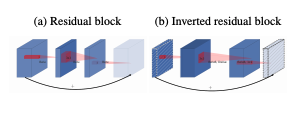

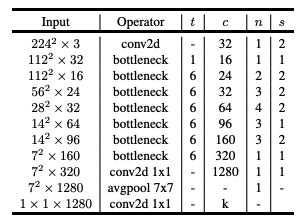

Here is the code to define the pre-trained MobileNetV2 model and print the model architecture:



In [ ]:
import torchvision
import torch.nn as nn

model = torchvision.models.mobilenet_v2(pretrained=True, progress=False)
model.classifier[1] = nn.Linear(1280, 10)
model

we define the pre-trained MobileNetV2 model and print the model architecture. The model has a series of convolutional layers followed by a fully connected layer that outputs the class scores. We can replace the last layer with a new layer that outputs the 5 facial landmarks.

we replace the last layer of the pre-trained MobileNetV2 model with a new layer that outputs the 5 facial landmarks. The new layer has 10 output units, corresponding to the 5 facial landmarks `(x, y)` coordinates.

**Loss function and optimizer**

Let’s define the loss function and optimizer for fine-tuning the pre-trained model. We can use the Mean Squared Error (MSE) loss function to measure the difference between the predicted and ground truth facial landmarks. We can use the Adam optimizer to update the model parameters based on the loss function.

In [9]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training and Evaluation

**Training loop**

Let’s define the training loop to fine-tune the pre-trained model. The training loop consists of iterating over the training dataset, forward and backward passes through the model, and updating the model parameters based on the loss function and optimizer.

In [ ]:
from tqdm import tqdm

model.to(device)
model.train()

for epoch in range(3):
    running_loss = 0.0
    bar = tqdm(enumerate(train_dataloader))
    for i, data in bar:
        inputs, labels = data['image'], data['landmarks']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.reshape(batch_size, 5, 2), labels)
        loss.to(device)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        bar.set_postfix(epoch=f'[{epoch + 1}, {i + 1}]', loss=running_loss)

**Test the model**

After fine-tuning the pre-trained model, we can test the model on the test dataset and evaluate its performance. We can define the evaluation loop to iterate over the test dataset, forward pass through the model, and compute the loss and accuracy.

In [ ]:
model.eval()

running_loss = 0.0

with torch.no_grad():
    bar = tqdm(enumerate(test_dataloader))
    for i, data in bar:
        inputs, labels = data['image'], data['landmarks']
        outputs = model(inputs)
        loss = criterion(outputs.reshape(batch_size, 5, 2), labels)
        running_loss += loss.item()
        bar.set_postfix(batch=i, loss=running_loss / len(test_dataloader), running_loss=running_loss)

**Evaluate the model**

We can evaluate the model prediction with the ground truth facial landmarks. We can define a function to compute the Euclidean distance between the predicted and ground truth facial landmarks.

In [12]:
def euclidean_dist(vector_x, vector_y):
    vector_x, vector_y = np.array(vector_x), np.array(vector_y)

    distance = np.sqrt(np.sum((vector_x - vector_y)**2, axis=-1))
    distance_y = np.sqrt(np.sum((vector_y[0] - vector_y[1])**2))

    normalized_distance = distance / distance_y
    return distance, normalized_distance

**Visualize the results**

Finally, we can visualize the results by plotting the images and predicted facial landmarks. We can define a function to plot the images and predicted facial landmarks.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
fig = plt.figure(figsize=(12, 12))

num_images = 12

for i in range(num_images):
    sample = test_dataset[i]
    inputs, labels = sample['image'], sample['landmarks']

    outputs = model(inputs.unsqueeze(0))
    outputs = (outputs.reshape(5, 2).cpu().detach().numpy() * 224).astype(int)
    landmarks = (labels.cpu().detach().numpy() * 224).astype(int)
    image = (inputs.cpu().permute(1, 2, 0).numpy() * 255).astype(int)

    ax = plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    distance, normalized_distance = euclidean_dist(outputs, landmarks)
    ax.set_title('Sample #{} distance {:.2f} \n normalized_distance {:.2f}'.format(i, np.sum(distance), np.sum(normalized_distance)))
    ax.axis('off')

    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=50, marker='.', c='g')
    plt.scatter(outputs[:, 0], outputs[:, 1], s=50, marker='.', c='r')

plt.show()

# Exercise

Now that you have a facial landmark detection model, combined with the facial expression recognition model we trained in the last lab, we can create an interesting tool that automatically captures people's emotions and adds special effects to specific landmark locations accordingly.

### Task-1

**Description**


Task1 is to enhance your understanding of the facial landmark detection model. You will complete the training of the facial landmark detection model using a new training set.

**Instructions**



*   Download and analyse the statistics of Exercise Dataset: https://wywu.github.io/projects/LAB/WFLW.html
*   Build dataloaders and model
*   Train and Evaluate the model


### Task-2

**Description**



Task 2 is about how to use a trained network for real-world applications. You will conduct a brief demonstration on automatically recognizing people's emotions and adding corresponding face filters. To add face effects to specific areas of the face, such as placing sunglasses over the eyes or adding facial hair below the nose, we need to determine the coordinates of these positions using a trained facial landmark detection model.

You can select samples from the WFLW dataset to use as test samples for Task 2.

**Instructions**

*   Build the Facial Expression Recognition (FER) Model and load the model weights trained on previous lab. You can use this [model weights](https://drive.google.com/file/d/1L2yN1N3h7KonhAcNglRRAHXIbdBkKxD9/view?usp=sharing) if you missed the first lab.
*   Build the Facial Landmark Detection model.
*   Assign specific accessories to each emotion along with their corresponding target areas on the face. The trained FER model identifies seven emotions, and you can focus on 'sad', 'anger', and 'happy'. For instance, you might choose a star accessory for happiness and tear for sad. This [website](https://www.flaticon.com/) may provides some useful accessories.
*   Predefine the target position for each accessory based on the corresponding emotion. For example, a tear should be positioned near the eyes, while other accessories can be placed according to their relevance to each emotion.
*   Build the demo. The deliverable is a facefilter function, which takes a face image as input and outputs the modified image with special effects. For instance, upon receiving a face image, the emotion of the person is first identified using the FER model. Based on this emotion, the appropriate accessory is selected. Next, facial landmarks are detected, allowing the accessory to be accurately positioned on the face.

**Notice:** The final submission must include all code, along with the corresponding input and output results. Please retain the output cells and present the results for each test case separately. Ensure that the submitted file displays all results without requiring any additional execution.